In [1]:
import sys
!{sys.executable} -m pip install numpy==1.18.5

You should consider upgrading via the '/home/amey/anaconda3/envs/tf/bin/python -m pip install --upgrade pip' command.


In [39]:
tf.__version__

'2.2.0'

In [40]:
import keras
keras.__version__

'2.4.3'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pickle
from tqdm import tqdm
import string
from collections import Counter

from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

In [3]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

In [5]:
file = open("Flickr8k.token.txt", "r")
txt = file.read()
file.close()
captions = txt.split("\n")
print(captions[10])

1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .


In [6]:
data_from_file = {}
for one_caption in captions[:-1]:
    img, one_caption = one_caption.split("\t")
    if img[:-2] not in data_from_file:
        data_from_file[img[:-2]] = [one_caption]
    else:
        data_from_file[img[:-2]].append(one_caption)

# Caption cleaning
table = str.maketrans("","", string.punctuation)
for img, captions in data_from_file.items():
    for i,img_caption in enumerate(captions):
        img_caption.replace("-", " ")
        temp = img_caption.split()
        temp = [word.lower() for word in temp]    # Convert all to lower case letters
        temp = [word.translate(table) for word in temp]  # remove punctuations
        temp = [word for word in temp if(len(word)>1)]   # remove "a" and "'s'" (length<=1) then remove
        temp = [word for word in temp if(word.isalpha())]  # check for non alphabets
        img_caption = " ".join(temp)
        data_from_file[img][i] = img_caption
        
# Now create a vocabulary of unique words
vocab = set()
for key in data_from_file.keys():
    [vocab.update(d.split()) for d in data_from_file[key]]

#saving above processed filenames and captions to a text file
line = list()
for key, temp_list in data_from_file.items():
    for temp in temp_list:
        line.append(key + "\t" + temp)
data_overall = "\n".join(line)
file = open("processed_captions.txt", "w")
file.write(data_overall)
file.close()

In [7]:
data_from_file["1000268201_693b08cb0e.jpg"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [8]:
len(vocab)

8763

In [9]:
# Loading name of images for train and test dataset
def img_id_names(file_name):
    with open(file_name) as file:
        data = file.readlines()
        img_name = []
        for img_id in data:
            img_name.append(img_id.split("\n")[0])
    return img_name

train_img_name = img_id_names("Flickr_8k.trainImages.txt")
test_img_name = img_id_names("Flickr_8k.testImages.txt")
print(len(test_img_name))
train_img_name[0]

1000


'2513260012_03d33305cf.jpg'

In [10]:
# Loading Captions and append them with start and end
def caption_sequence_definer(file_name):
    with open(file_name) as file:
        doc = file.readlines()
    train_captions = {}
    
    for line in doc:
        tokens = line.split()
        img_id, img_cap = tokens[0], tokens[1:]
        if (img_id in train_img_name):
            if (img_id not in train_captions):
                train_captions[img_id] = []
            modified_cap = "startseq " + " ".join(img_cap) + " endseq"
            train_captions[img_id].append(modified_cap)
    return (train_captions)
train_captions = caption_sequence_definer("processed_captions.txt")
train_captions["1000268201_693b08cb0e.jpg"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


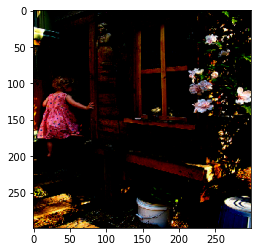

In [11]:
# Preprocess Images
def preprocess_img(img_path):
    img = load_img(img_path, target_size = (299,299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)       # Now having 4 dimensions (None, 299,299,3)
    img = preprocess_input(img)
    return(img)
img = preprocess_img("Flicker8k_Dataset/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])

## Transfer Learning : InceptionV3 Model
input(299,299,3) <br>
48 layers deep <br>
1000 categories (keyboard, mouse, painting, etc)<br>
Trained on : ImageNet dataset <br>


In [12]:
model = InceptionV3(weights = "imagenet")
# Now removing the output layer of the InceptionV3 model 
new_model = Model(inputs = model.input, outputs = model.layers[-2].output)
#new_model.predict(img).shape

Output layer have 2048 neurons dense

In [13]:
def images_name(path):
    img_name = set([path + image for image in os.listdir(path)])
    return img_name

path = "Flicker8k_Dataset/"
all_images_name = images_name(path)
train_img_name = [path+img for img in train_img_name]
test_img_name = [path+img for img in test_img_name]

Encoding Already done below, do not run again

In [14]:
def encode_image(image):
    image = preprocess_img(image)
    feature_vector = new_model.predict(image) # gives (, 2048)
    feature_vector = feature_vector.reshape(feature_vector.shape[1], ) # gives (2048, )
    return feature_vector

# Now encoding all images
encoding_train = {}
for idx, img in tqdm(enumerate(train_img_name)):
    encoding_train[img] = encode_image(img)

60it [00:23,  2.58it/s]


KeyboardInterrupt: 

In [ ]:
# now Encoding all test Image
encoding_test = {}
for idx, img in tqdm(enumerate(test_img_name)):
    encoding_test[img] = encode_image(img)

In [14]:
# Saving the encodings
#with open("encoding_train_images.pkl", "wb") as encoding_file:
#    pickle.dump(encoding_train, encoding_file)
#with open("encoding_test_images.pkl", "wb") as encoding_file:
#    pickle.dump(encoding_test, encoding_file)

In [17]:
# Load the encodings
train_features = pickle.load(open("encoding_train_images.pkl", "rb"))
train_captions_all = []
for captions in train_captions.values():
    for caption in captions:
        train_captions_all.append(caption)
print(train_captions_all[0])
print(train_captions_all[1])

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq


In [18]:
corpus = []
for caption in train_captions_all:
    for token in caption.split():
        corpus.append(token)

count_map = Counter(corpus)
vocab = []
for token, count in count_map.items():
    if (count >= 10):
        vocab.append(token)
    
print('Number of original tokens',len(count_map))
print('Number of tokens after threshold',len(vocab))

Number of original tokens 7578
Number of tokens after threshold 1651


In [19]:
# Index to word and word to index map
word_to_index = {}
index_to_word = {}

for idx, token in enumerate(vocab):
    word_to_index[token] = idx + 1
    index_to_word[idx + 1] = token
vocab_size = len(index_to_word) + 1

def max_length_caption(train_captions_all):
    max_len = 0
    for caption in train_captions_all:
        max_len = max(max_len, len(caption.split()))
    return max_len
max_length_caption = max_length_caption(train_captions_all)
max_length_caption

34

In [20]:
len(vocab)

1651

In [22]:
# data generator
#def data_generator(train_captions, train_features, wordtoidx, max_length, num_imgs_per_batch):
#    X1, X2, y = list(), list(), list()
#    n = 0
#    for key, cap_list in train_captions.items():
#        n = n+1
#        temp = "Flicker8k_Dataset/"
#        photo = train_features["Flicker8k_Dataset/" + key]
#        for cap in cap_list:
#            # Encoding the sequence 
#            seq = [wordtoidx[word] for word in cap.split(" ") if word in wordtoidx]
#            # splitting above seq into X,y pairs
#            for i in range(1, len(seq)):
#                in_seq, out_seq = seq[:i], seq[i]
#                in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
#                out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
#                    
#                X1.append(photo)
#                X2.append(in_seq)
#                y.append(out_seq)
#   return ([[np.array(X1), np.array(X2)], np.array(y)])
    
    
### Problem of above representation is that the memory of these arrays increases to 3.1GB so not recomended

In [21]:
# data generator
def data_generator(train_captions, train_features, wordtoidx, max_length, num_imgs_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key, cap_list in train_captions.items():
            n = n+1
            temp = "Flicker8k_Dataset/"
            photo = train_features["Flicker8k_Dataset/" + key]
            for cap in cap_list:
                # Encoding the sequence 
                seq = [wordtoidx[word] for word in cap.split(" ") if word in wordtoidx]
                # splitting above seq into X,y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == num_imgs_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [23]:
# Loading GloVe vectors
embeddings_index = {}
glove_vec = open("glove.6B.200d.txt", encoding = "utf-8")

for line in glove_vec:
    values = line.split()
    word = values[0]
    coeffs = np.asarray(values[1:], dtype = "float32")
    embeddings_index[word] = coeffs
glove_vec.close()
print(len(embeddings_index))

400000


In [24]:
# creating 200 dim vector for each words in vocab
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(1652, 200)

In [25]:
inputs1 = Input(shape = (2048, ))
ph1 = Dropout(0.5)(inputs1)
ph2 = Dense(256, activation = "relu")(ph1)

inputs2 = Input(shape = (max_length_caption, ))
seq1 = Embedding(vocab_size, embedding_dim, mask_zero = True)(inputs2)
seq2 = Dropout(0.5)(seq1)
seq3 = LSTM(256)(seq2)

decoder1 = add([ph2, seq3])
decoder2 = Dense(256, activation = "relu")(decoder1)
outputs = Dense(vocab_size, activation = "softmax")(decoder2)


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [26]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [27]:
# Fix weights 
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [28]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=["categorical_crossentropy", "accuracy"])

In [29]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 12
steps = len(train_captions)//number_pics_per_batch

temp='Flicker8k_Dataset/'
temp

'Flicker8k_Dataset/'

In [ ]:
for i in range(epochs):
    generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model___' + str(i) + '.h5')

402/500 [=======================>......] - ETA: 2:15 - loss: 2.3156 - categorical_crossentropy: 2.3156 - accuracy: 0.4157

In [38]:
for i in range(8):
    generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model___new' + str(i) + '.h5')

500/500 [==============================] - 628s 1s/step - loss: 2.3145 - categorical_crossentropy: 2.3145 - accuracy: 0.4148


In [34]:
#model.load_weights("model___new4.h5")
# next time load froom model___new4

In [35]:

with open("encoding_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)
    
def Img_predictor(photo):
    in_text = 'startseq'
    for i in range(max_length_caption):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length_caption)
        yhat = model.predict([photo,sequence], 
                             verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

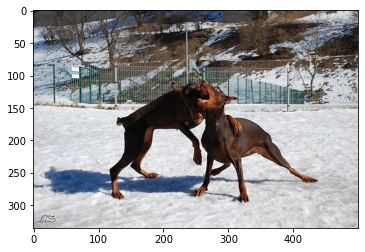

Title : brown dog is running through the snow


In [36]:
pic = list(encoding_test.keys())[0]
image = encoding_test[pic].reshape((1,2048))
x = plt.imread(pic)
plt.imshow(x)
plt.show()
print("Title :",Img_predictor(image))

In [ ]:
## EOF ##

In [55]:
train_captions

{'1000268201_693b08cb0e.jpg': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70.jpg': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8.jpg': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted r